In [1]:
from dotenv import load_dotenv
import os

load_dotenv('../.env')

True

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2:3b", base_url="http://localhost:11434")

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)


graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()



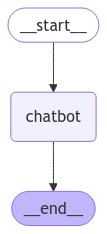

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


def run_graph(user_input:str):
    output = graph.invoke({"messages": [("user", user_input)]})
    print(output)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        # stream_graph_updates(user_input)
        run_graph(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='f9eec3be-39a4-437c-bcfd-79aa988882bb'), AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2024-11-18T09:44:56.5481648Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 339661600, 'load_duration': 19309000, 'prompt_eval_count': 26, 'prompt_eval_duration': 206619000, 'eval_count': 8, 'eval_duration': 111859000}, id='run-77b1e80a-36b9-404e-9630-1c904ff04619-0', usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34})]}
Goodbye!


### Part 2: Enhancing the Chatbot with Tools

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state"},
 {'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': 'Each node in a LangGraph graph has the ability to access, read, and write to the state. When a node modifies the state, it effectively broadcasts this information to all other nodes within the graph .'}]

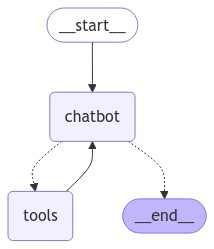

In [17]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatOllama(model="llama3.2:3b", base_url="http://localhost:11434")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()


display(Image(graph.get_graph().draw_mermaid_png()))


In [18]:
def run_graph(user_input:str):
    output = graph.invoke({"messages": [("user", user_input)]})
    print(output)

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    # stream_graph_updates(user_input)
    run_graph(user_input)


{'messages': [HumanMessage(content="what is mumbai's temperature today?", additional_kwargs={}, response_metadata={}, id='22c512a7-b9f9-47ad-9928-d1769e22df9a'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2024-11-18T12:11:08.9624028Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'tavily_search_results_json', 'arguments': {'query': 'Mumbai temperature today'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 2040171900, 'load_duration': 1621952600, 'prompt_eval_count': 194, 'prompt_eval_duration': 101026000, 'eval_count': 24, 'eval_duration': 314829000}, id='run-3dfcbf7e-625f-4e14-bf47-f9cd99e7eae3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Mumbai temperature today'}, 'id': 'b53b6dbe-85d3-40a2-bd2b-4625213fc348', 'type': 'tool_call'}], usage_metadata={'input_tokens': 194, 'output_tokens': 24, 'total_tokens': 218}), ToolMessage(content='[{"url": "ht

### Part 3: Adding Memory to the Chatbot¶

- LangGraph solves this problem through persistent checkpointing. If you provide a checkpointer when compiling the graph and a thread_id when calling your graph, LangGraph automatically saves the state after each step

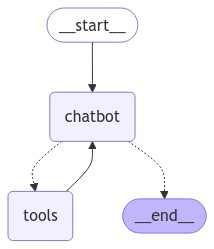

In [20]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)
memory = MemorySaver()


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOllama(model="llama3.2:3b", base_url="http://localhost:11434")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [23]:
config = {"configurable": {"thread_id": "1"}}

def run_graph(user_input:str, config: dict):
    output = graph.invoke({"messages": [("user", user_input)]}, config=config)
    print(output['messages'][-1].pretty_print())

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    # stream_graph_updates(user_input)
    run_graph(user_input, config=config)

================================== Ai Message ==================================

Hello again Laxmi Kant Tiwari,

It seems like my previous search results were not accurate. However, I have found some new information about you.

You can be found on LinkedIn with the profile link: https://www.linkedin.com/in/laxmi-kant-tiwari-243379ba

Additionally, you are currently an Associate Professor at Chandigarh University in India and have over 500 connections on LinkedIn. 

Would you like to know more about anything specific or is there something I can assist you with?
None
================================== Ai Message ==================================

Your name is Laxmi Kant Tiwari. I apologize for the earlier mistake where I had "Laxmi kant Tiwari" instead of the correct spelling. It seems like you are an Associate Professor at Chandigarh University and have experience in data science, team management, and business development. You can also be found on LinkedIn and Udemy with your profile 

## Part 4: Human-in-the-loop